In [ ]:
# Install required packages
!pip install tensorflow scikit-learn matplotlib seaborn

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
# Define paths to your datasets
train_dir = '/content/drive/MyDrive/Retinal fundus images for DR/1.train'
val_dir = '/content/drive/MyDrive/Retinal fundus images for DR/2.val'
test_dir = '/content/drive/MyDrive/Retinal fundus images for DR/3.test'

In [ ]:
# Data normalization
datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 638 images belonging to 7 classes.
Found 136 images belonging to 7 classes.
Found 143 images belonging to 7 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [ ]:
# Define the ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the model with early stopping
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=15,  # Set a higher number of epochs, early stopping will handle it
    callbacks=[early_stopping]
)
training_time = time.time() - start_time

print(f"Training time: {training_time:.2f} seconds")

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 581s 30s/step - accuracy: 0.1628 - loss: 3.2429 - val_accuracy: 0.2500 - val_loss: 1.9415
Epoch 2/15
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.3438 - loss: 2.0098

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 495ms/step - accuracy: 0.3438 - loss: 2.0098 - val_accuracy: 0.2656 - val_loss: 1.9298
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.2324 - loss: 1.9106 - val_accuracy: 0.2969 - val_loss: 1.8675
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - accuracy: 0.1875 - loss: 1.9455 - val_accuracy: 0.3672 - val_loss: 1.8496
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2393 - loss: 1.9065 - val_accuracy: 0.2734 - val_loss: 1.8785
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step - accuracy: 0.3125 - loss: 1.8389 - val_accuracy: 0.3516 - val_loss: 1.8769
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.2298 - loss: 1.8750 - val_accuracy: 0.3750 - val_loss: 1.8738
Training time: 794.17 seconds


In [ ]:
# Evaluate the model
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.labels # Remove np.argmax here

5/5 ━━━━━━━━━━━━━━━━━━━━ 79s 18s/step


In [ ]:

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, target_names=list(train_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.3217
Classification Report:
                          precision    recall  f1-score   support

         1. No DR signs       0.00      0.00      0.00        29
2. Mild (or early) NPDR       0.31      0.92      0.46        26
       3. Moderate NPDR       0.00      0.00      0.00        12
         4. Severe NPDR       0.34      0.81      0.48        27
    5. Very Severe NPDR       0.00      0.00      0.00        17
                 6. PDR       0.00      0.00      0.00        14
        7. Advanced PDR       0.00      0.00      0.00        18

               accuracy                           0.32       143
              macro avg       0.09      0.25      0.13       143
           weighted avg       0.12      0.32      0.17       143



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


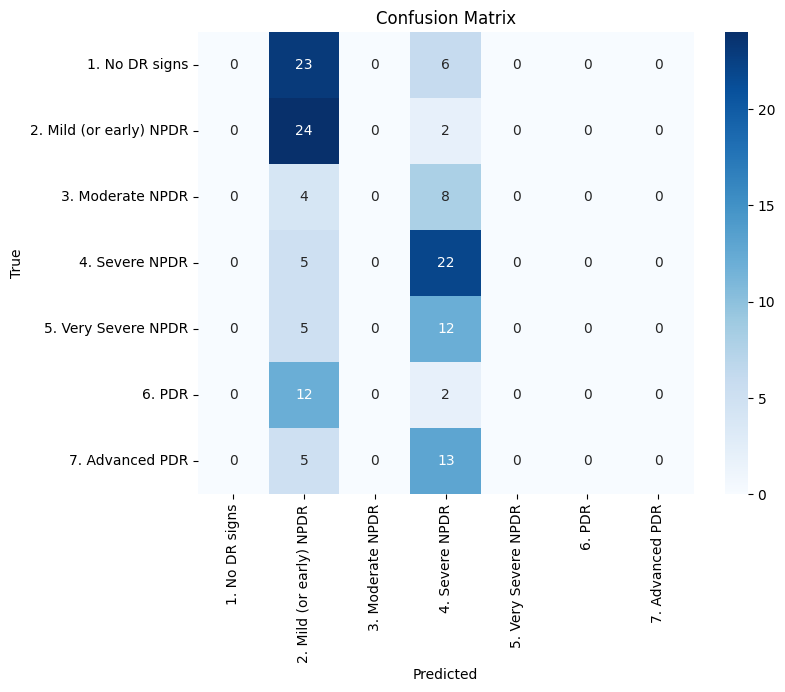

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()